In [1]:
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (10, 9)
import scipy.optimize
import pandas as pd 
import numpy as np
from numpy.linalg import inv

In [2]:
# Calculates portfolio mean return
def get_mean(W, R):
    return sum(R * W)

# Calculates portfolio variance of returns
def get_var(W, C):
    return np.dot(np.dot(W, C), W)
    
# 포트폴리오 수익률 평균 및 분산
def get_mean_var(W, R, C):
    return sum(R * W), np.dot(np.dot(W, C), W)

In [3]:
# 무위험수익률, 수익률,공분산으로 평균-분산 프런티어 계산
def solveFrontier(R, C, rf):
    def fitness(W, R, C, r):
        # 주어진 수익률에서 분산을 최소로 하는 비중 계산
        mean = sum(R * W)
        var = np.dot(np.dot(W, C), W)
        # 최적화 제약조건 페널티
        penalty = 100 * abs(mean - r)             
        return var + penalty

    frontier_mean, frontier_var = [], []
    n = len(R)  # 투자자산 갯수
    # 수익률 최저~최대 사이를 반복한다
    for r in np.linspace(min(R), max(R), num=20):  # Iterate through the range of returns on Y axis
        # 최적화 함수에 전달할 초기값으로 동일비중으로 시작한다
        W = np.ones([n]) / n 
        # 최적화 함수에 전달할 제약조건을 미리 준비한다
        b_ = [(0, 1) for i in range(n)]
        c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})
        # 최적화 함수 minimize()은 최적화할 함수와 최적화를 시작할 초깃값을 인수로 받는다. 
        # fitness가 최적화할 함수이다.
        optimized = scipy.optimize.minimize(fitness, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_)
        if not optimized.success:
            raise BaseException(optimized.message)
        # add point to the efficient frontier [x,y] = [optimized.x, r]
        # 효율적 프런티어에 포트폴리오 하나를 추가
        frontier_mean.append(r)
        frontier_var.append(get_var(optimized.x, C))
    return np.array(frontier_mean), np.array(frontier_var)

In [4]:
# 무위험수익률, 수익률,공분산으로
# 샤프비율을 최대로 하는 접점포트폴리오 비중 계산 
def solveWeights(R, C, rf):
    def fitness(W, R, C, rf):
        mean, var = get_mean_var(W, R, C)  # calculate mean/variance of the portfolio
        util = (mean - rf) / np.sqrt(var)  # utility = Sharpe ratio
        return 1 / util  # maximize the utility, minimize its inverse value
    n = len(R)
    W = np.ones([n]) / n  # start optimization with equal weights
    b_ = [(0., 1.) for i in range(n)]  # weights for boundaries between 0%..100%. No leverage, no shorting
    c_ = ({'type': 'eq', 'fun': lambda W: sum(W) - 1.})  # Sum of weights must be 100%
    optimized = scipy.optimize.minimize(fitness, W, (R, C, rf), method='SLSQP', constraints=c_, bounds=b_)
    if not optimized.success: 
      raise BaseException(optimized.message)
    return optimized.x

In [5]:
# 여러 개의 값을 한 번에 돌려주기 위한 클래스, 
# 즉 여러 개의 물건을 한번에 옮기기 위한 상자로 생각하면 된다
class Result:
    def __init__(self, W, tan_mean, tan_var, front_mean, front_var):
        self.W=W
        self.tan_mean=tan_mean
        self.tan_var=tan_var
        self.front_mean=front_mean
        self.front_var=front_var

# 효율적 포트폴리오 최적화        
def optimize_frontier(R, C, rf):
    W = solveWeights(R, C, rf)
    tan_mean, tan_var = get_mean_var(W, R, C)  # calculate tangency portfolio
    front_mean, front_var = solveFrontier(R, C, rf)  # calculate efficient frontier
    # Weights, Tangency portfolio asset means and variances, Efficient frontier means and variances
    return Result(W, tan_mean, tan_var, front_mean, front_var)

def display_assets(names, R, C, color='black'):
    n = len(names)
    plt.scatter([C[i, i] ** .5 for i in range(n)], R, marker='x', color=color), plt.grid(True)  # draw assets
    for i in range(n): 
        plt.text(C[i, i] ** .5, R[i], '  %s' % names[i], verticalalignment='center', color=color) # draw labels

def display_frontier(result, label=None, color='black'):
    plt.text(result.tan_var ** .5, result.tan_mean, '   tangent', verticalalignment='center', color=color)
    plt.scatter(result.tan_var ** .5, result.tan_mean, marker='o', color=color), plt.grid(True)
    plt.plot(result.front_var ** .5, result.front_mean, label=label, color=color), plt.grid(True)  # draw efficient frontier

In [6]:
df= pd.read_csv("미국ETF_9개.CSV");df.head()

,rdate,name,ticker,close,volume,market_cap,segment
0,2017-11-02,ProShares K-1 Free Crude Oil Strategy ETF,OILK,20.99,1250,74258623.0,Commodities: Energy Crude Oil
1,2017-11-03,ProShares K-1 Free Crude Oil Strategy ETF,OILK,21.32,3680,74258623.0,Commodities: Energy Crude Oil
2,2017-11-06,ProShares K-1 Free Crude Oil Strategy ETF,OILK,21.98,7450,74258623.0,Commodities: Energy Crude Oil
3,2017-11-07,ProShares K-1 Free Crude Oil Strategy ETF,OILK,21.92,5170,74258623.0,Commodities: Energy Crude Oil
4,2017-11-08,ProShares K-1 Free Crude Oil Strategy ETF,OILK,21.79,20010,74258623.0,Commodities: Energy Crude Oil


In [7]:
# symbols = ['OILK', 'BBCA', 'BBEU', 'SPHB', 'JAGG', 'BBJP', 'ARKK', 'PALL', 'QQQ']
# cap = {'OILK': 74258623, 'BBCA': 5659077206, 'BBEU': 8671311087, 'SPHB': 1889317500
# , 'JAGG': 1124737008,'BBJP': 8764382985
# , 'ARKK': 22393215000
# , 'PALL': 528330000
# , 'QQQ': 1.43E+11
# }

In [25]:
# 311 / 221 / 131 / 122 / 113
#[74258623, 5659077206, 8671311087, 889317500 ,1124737008, 8764382985, 22393215000, 528330000,1.43E+11]

In [101]:
# 공격형
symbols = ['OILK', 'BBCA', 'BBEU', 'BBJP', 'ARKK']
tickers=['OILK', 'BBCA', 'BBEU', 'BBJP', 'ARKK']
names=['OILK', 'BBCA', 'BBEU', 'BBJP', 'ARKK']
caps = [74258623, 5659077206, 8671311087, 8764382985, 22393215000]

In [37]:
# 221
symbols = ['OILK', 'BBCA', 'SPHB', 'JAGG', 'ARKK']
tickers=['OILK', 'BBCA', 'SPHB', 'JAGG', 'ARKK']
names=['OILK', 'BBCA', 'SPHB', 'JAGG', 'ARKK']
caps = [74258623, 5659077206, 889317500 ,1124737008,  22393215000]

In [51]:
# 131
symbols = ['OILK', 'SPHB', 'JAGG', 'BBJP', 'ARKK']
tickers=['OILK', 'SPHB', 'JAGG', 'BBJP', 'ARKK']
names=['OILK', 'SPHB', 'JAGG', 'BBJP', 'ARKK']
caps = [74258623, 889317500 ,1124737008, 8764382985, 22393215000]

In [61]:
# 122
symbols = ['OILK', 'SPHB', 'BBJP', 'ARKK', 'PALL']
tickers=['OILK', 'SPHB', 'BBJP', 'ARKK', 'PALL']
names=['OILK', 'SPHB', 'BBJP', 'ARKK', 'PALL']
caps = [74258623, 889317500 , 8764382985, 22393215000, 528330000]

In [71]:
# 113
symbols = ['OILK', 'BBJP', 'ARKK', 'PALL', 'QQQ']
tickers=['OILK', 'BBJP', 'ARKK', 'PALL', 'QQQ']
names=['OILK', 'BBJP', 'ARKK', 'PALL', 'QQQ']
caps = [74258623, 8764382985, 22393215000, 528330000,1.43E+11]

In [106]:
prices = []
for s in symbols:
    prices_out = df[df['ticker']==s]['close'][-650:].tolist()
    prices.append(prices_out)

In [107]:
# prices = []
# for s in symbols:
#   prices_out = close[close['ticker']==s]['close'][-800:].tolist()
#   prices.append(prices_out)

In [108]:
cap = {}

In [109]:
n = len(tickers)
W = np.array(caps) / sum(caps) # 시가총액의 비율계산
prices = np.matrix(prices)  # prices를 numpy matrix로 변환

# 수익률 행렬을 만들어 계산
rows, cols = prices.shape
returns = np.empty([rows, cols - 1])
for r in range(rows):
    for c in range(cols - 1):
        p0, p1 = prices[r, c], prices[r, c + 1]
        returns[r, c] = (p1 / p0) - 1

# 수익률계산
expreturns = np.array([])
for r in range(rows):
    expreturns = np.append(expreturns, np.mean(returns[r]))

# 공분산계산
covars = np.cov(returns)
R = (1 + expreturns) ** 250 - 1  # 연율화
C = covars * 250  # 연율화

# 무위험 이자율
rf = .015

In [110]:
display(pd.DataFrame({'Return': R, 'Weight (based on market cap)': W}, index=names).T)

,OILK,BBCA,BBEU,BBJP,ARKK
Return,-0.047621,0.761607,0.689426,0.647229,0.611383
Weight (based on market cap),0.001630,0.124205,0.190318,0.192361,0.491486


In [111]:
display(pd.DataFrame(C, columns=names, index=names))

,OILK,BBCA,BBEU,BBJP,ARKK
OILK,0.247232,0.060715,0.045423,0.026035,0.056548
BBCA,0.060715,0.450491,0.432622,0.416618,0.064745
BBEU,0.045423,0.432622,0.428828,0.412708,0.056619
BBJP,0.026035,0.416618,0.412708,0.411244,0.042594
ARKK,0.056548,0.064745,0.056619,0.042594,0.163489


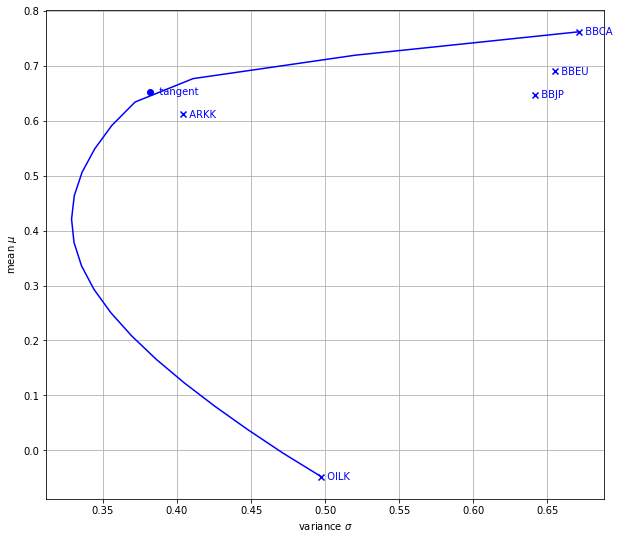

,OILK,BBCA,BBEU,BBJP,ARKK
Weight,2.041606e-17,0.274701,1.602481e-18,6.392775e-19,0.725299


In [112]:
res1 = optimize_frontier(R, C, rf)

display_assets(names, R, C, color='blue')
display_frontier(res1, color='blue')
plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.show()
display(pd.DataFrame({'Weight': res1.W}, index=names).T)

In [113]:
# Calculate portfolio historical return and variance
mean, var = get_mean_var(W, R, C)

lmb = (mean - rf) / var  # Calculate risk aversion
Pi = np.dot(np.dot(lmb, C), W)  # Calculate equilibrium excess returns

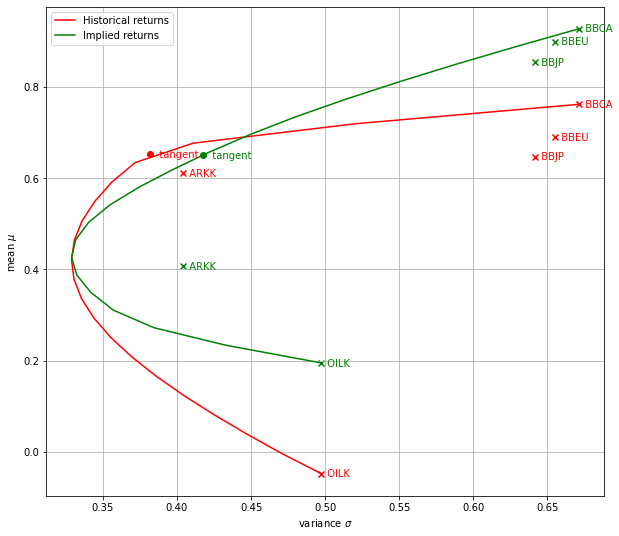

,OILK,BBCA,BBEU,BBJP,ARKK
Weight,0.001369,0.127038,0.181177,0.198093,0.492323


In [114]:
res2 = optimize_frontier(Pi+rf, C, rf)

display_assets(names, R, C, color='red')
display_frontier(res1, label='Historical returns', color='red')
display_assets(names, Pi+rf, C, color='green')
display_frontier(res2, label='Implied returns', color='green')
plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.legend(), plt.show()
display(pd.DataFrame({'Weight': res2.W}, index=names).T)

In [115]:
def create_views_and_link_matrix(names, views):
    r, c = len(views), len(names)
    Q = [views[i][3] for i in range(r)]  # view matrix
    P = np.zeros([r, c])
    nameToIndex = dict()
    for i, n in enumerate(names):
        nameToIndex[n] = i
    for i, v in enumerate(views):
        name1, name2 = views[i][0], views[i][2]
        P[i, nameToIndex[name1]] = +1 if views[i][1] == '>' else -1
        P[i, nameToIndex[name2]] = -1 if views[i][1] == '>' else +1
    return np.array(Q), P

views = [('PALL', '>', 'QQQ', 0.02),
         ('BBJP', '<', 'OILK', 0.02)]

Q, P = create_views_and_link_matrix(names, views)
print('Views Matrix')
display(pd.DataFrame({'Views':Q}))
print('Link Matrix')
display(pd.DataFrame(P))

KeyError: 'PALL'

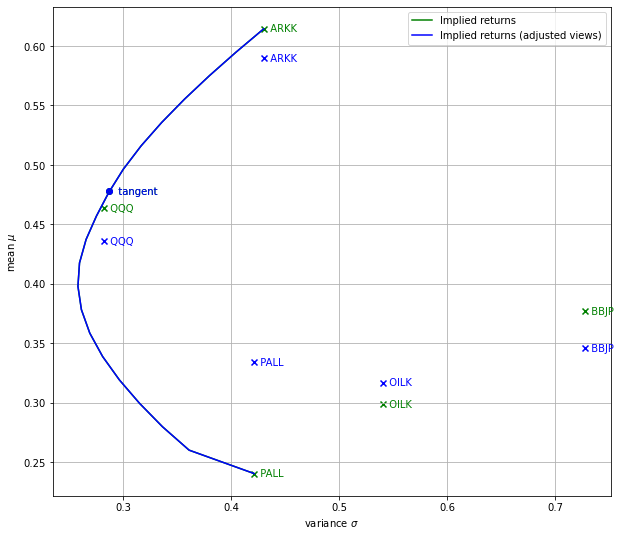

,OILK,BBJP,ARKK,PALL,QQQ
Weight,0.000472,0.050297,0.127942,0.003093,0.818197


In [86]:
tau = .025  # scaling factor

# Calculate omega - uncertainty matrix about views
omega = np.dot(np.dot(np.dot(tau, P), C), np.transpose(P))  # 0.025 * P * C * transpose(P)
# Calculate equilibrium excess returns with views incorporated
sub_a = inv(np.dot(tau, C))
sub_b = np.dot(np.dot(np.transpose(P), inv(omega)), P)
sub_c = np.dot(inv(np.dot(tau, C)), Pi)
sub_d = np.dot(np.dot(np.transpose(P), inv(omega)), Q)
Pi_adj = np.dot(inv(sub_a + sub_b), (sub_c + sub_d))

res3 = optimize_frontier(Pi + rf, C, rf)

display_assets(names, Pi+rf, C, color='green')
display_frontier(res2, label='Implied returns', color='green')
display_assets(names, Pi_adj+rf, C, color='blue')
display_frontier(res3, label='Implied returns (adjusted views)', color='blue')
plt.xlabel('variance $\sigma$'), plt.ylabel('mean $\mu$'), plt.legend(), plt.show()
display(pd.DataFrame({'Weight': res2.W}, index=names).T)